In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd

from config import CRS

import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

In [3]:
filepath = os.path.join("data", "processed", "buildings.gpkg")
gdf = gpd.read_file(filepath, driver="GPKG")
gdf.crs = CRS
gdf.head(2)

ID_bat  ID_Concept EA_Heat  EA_HW  HeatPower      Need_Heat       Need_HW  \
0       8           0     gas    gas       84.0  120228.496894  40130.033035   
1      16           0   other  other       11.0   19659.863597    990.071041   

          SRE  TempLevel             Allocation        Epoch  SIA  GridArea  \
0  477.738489         70  indoor swimming pools            0   12         0   
1  141.580300         70         administration  .... - 1919    3         0   

   MaxSurf_PV_m2  CoolPower                                           geometry  
0            418        1.0  POLYGON ((333618.3162912441 5148286.238886707,...  
1             71        3.0  POLYGON ((333781.8668657038 5148335.068558921,...

In [4]:
filepath = os.path.join("data", "external", "scenarii", "sce1", "sce1.shp")
sce = gpd.read_file(filepath).to_crs(crs=CRS)
sce.rename(columns={"concept": "ID_Concept_ICT"}, inplace=True)
sce = sce.loc[sce.ID_Concept_ICT != "None"]

In [5]:
data = gpd.sjoin(gdf, sce, how='left', op='within', rsuffix="sce")
data.drop("index_sce", axis=1, inplace=True)
data.fillna("NoConcept", inplace=True)
data.head(2)

ID_bat  ID_Concept EA_Heat  EA_HW  HeatPower      Need_Heat       Need_HW  \
0       8           0     gas    gas       84.0  120228.496894  40130.033035   
1      16           0   other  other       11.0   19659.863597    990.071041   

          SRE  TempLevel             Allocation        Epoch  SIA  GridArea  \
0  477.738489         70  indoor swimming pools            0   12         0   
1  141.580300         70         administration  .... - 1919    3         0   

   MaxSurf_PV_m2  CoolPower  \
0            418        1.0   
1             71        3.0   

                                            geometry ID_Concept_ICT  
0  POLYGON ((333618.3162912441 5148286.238886707,...      NoConcept  
1  POLYGON ((333781.8668657038 5148335.068558921,...      NoConcept

<IPython.core.display.Javascript object>


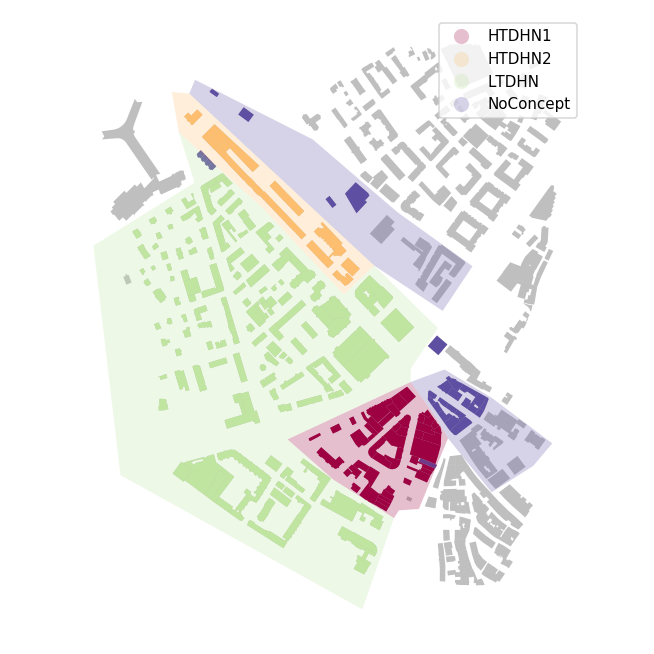

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis("off")

data.loc[data.GridArea == 1].plot(ax=ax, color="k", alpha=0.25)
data.loc[data.ID_Concept == 12].plot(ax=ax, column="ID_Concept_ICT", cmap="Spectral")
sce.plot(ax=ax, column="ID_Concept_ICT", alpha=0.25, legend=True, cmap="Spectral")

plt.tight_layout()
plt.savefig(os.path.join("images", "scenario.png"), dpi=150, bbox_inches="tight")

<IPython.core.display.Javascript object>


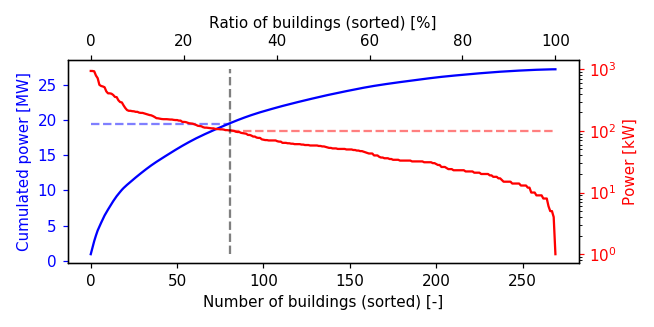

In [7]:
p = data.loc[data.ID_Concept == 12].sort_values("HeatPower", ascending=False)["HeatPower"]
y = p.cumsum()*1e-3
x = range(len(y))

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(x, y, 'b-')

ax.set_xlabel("Number of buildings (sorted) [-]")
ax.set_ylabel("Cumulated power [MW]", color='b')
ax.tick_params('y', colors='b')

ax1 = ax.twinx()
ax1.set_yscale("log")
ax1.plot(x, p, 'r-')

ax1.set_ylabel("Power [kW]", color='r')
ax1.tick_params('y', colors='r')

ax2 = ax1.twiny()
ax2.plot(np.linspace(0, 100, num=len(p)), p, alpha=0)
ax2.set_xlabel("Ratio of buildings (sorted) [%]")
ax2.vlines(30, 1, 1e3, linestyles="dashed", alpha=0.5)

ax.hlines(19.5, 0, 81, linestyles="dashed", alpha=0.5, color='b')
ax1.hlines(100, 81, x[-1], linestyles="dashed", alpha=0.5, color='r')

plt.tight_layout()
plt.savefig(os.path.join("images", "pcurve.png"), dpi=150, bbox_inches='tight')

In [8]:
select = data.loc[data.ID_Concept_ICT.isin(["HTDHN1", "HTDHN2", "LTDHN"])]
select = select.loc[select.HeatPower > 100]
to_remove = select.loc[(select.TempLevel >= 70) & (select.ID_Concept_ICT == "LTDHN")].index
select.drop(to_remove, inplace=True)

data["SELECT"] = 0
data.loc[select.index, "SELECT"] = 1

<IPython.core.display.Javascript object>


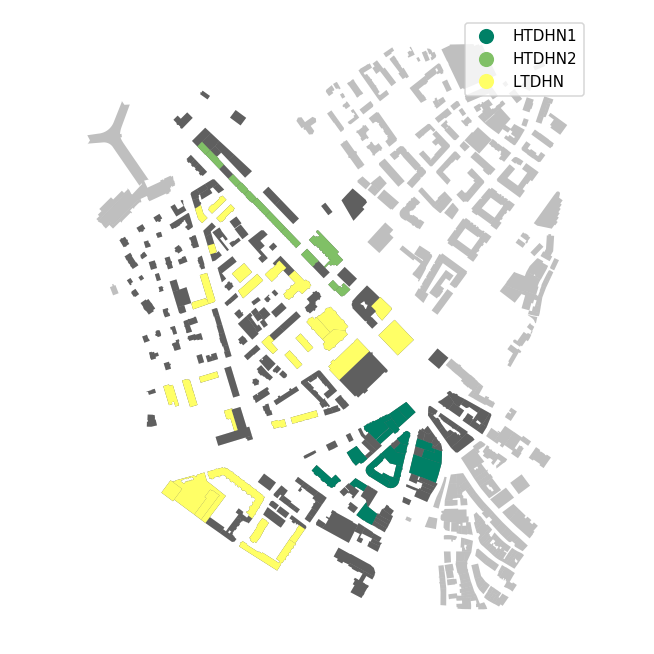

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis("off")

data.loc[data.GridArea == 1].plot(ax=ax, color="k", alpha=0.25)
data.loc[data.ID_Concept == 12].plot(ax=ax, color="k", alpha=0.5)
select.plot(ax=ax, column="ID_Concept_ICT", cmap="summer", legend=True, categorical=True)

plt.tight_layout()
plt.savefig(os.path.join("images", "select.png"), dpi=150, bbox_inches='tight')

In [10]:
filepath = os.path.join("data", "processed", "scenario.gpkg")
data.to_file(filepath, driver="GPKG")